In [377]:
#Questions:
""" GERON
Note that since instances are picked randomly, some instances may be picked several times per epoch
while others may not be picked at all. If you want to be sure that the algorithm goes through every instance
at each epoch, another approach is to shuffle the training set, then go through it instance by instance, then
shuffle it again, and so on. However, this generally converges more slowly.

""";

# stratified train test split

#  For LogReg
# mix? sgd for a while, then gd? PRØV
# regularization is cool i guess? finding the lowest minima = overfitting? japp
# could add the svd madness as LR? prøv


#network
# more lr methods? kanskja Adam, usikker? prøv. også momentum gd
# more inits? xavier+kaiming
# husk drop out for NN!
# markov dropout? husk å dele på drop out sannsynligheten. SB ps sannsynlighets estimat som regularisering.
# batch normalization
#dropout drop different nodes forward and bacwards? 

In [256]:
#ToDo:
# make more lr and init methods
#mix? sgd for a while, then gd?
#sgd no shuffle
#regularization in optimization!
# could add the svd madness as LR?
#stratified?

In [81]:
#importing packages
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
import scipy.linalg as scl

In [ ]:
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                  test_size = 1-trainingShare,
                                                 random_state=seed)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

In [296]:
def sigmoid(s): # can be shortened to: return 1./(1.+np.exp(-s))
#     out = np.zeros(s.shape)
#     for i,S in enumerate(s):
#         out[i]= 1./(1.+np.exp(-S)) #try just outwith small s, specify axis?
#     return out
    return 1./(1.+np.exp(-s))

In [11]:
def Gradient(X,theta,y):
    return (X.T@(sigmoid(X@theta)-y))

In [12]:
def CostFunction(X,theta,y):
    y_pred= sigmoid(X@theta)
    y_pred_neg = sigmoid(-X@theta)
    cost__ = -y*np.log(y_pred)-(1-y)*np.log(y_pred_neg)
    cost_ = np.sum(cost__,axis=0)
#     print(cost__)
    return cost_/len(y)

In [13]:
"""
Takes two arrays of equal length and calculates the "Accuracy score"
"""
def Accuracy(t,y):
    assert len(t)==len(y), "y and y_pred dimensions do not match ({},{}).".format(len(t),len(y))
    s = [1 if i else 0 for i in np.equal(t,y)]
    return np.sum(s)/len(t)

In [14]:
"""
this function is pretty much stolen from
https://stackoverflow.com/questions/38157972/how-to-implement-mini-batch-gradient-descent-in-python
users Ash and dsachar
"""
def BatchIterator(X,y,batch_size,shuffle=True):
    assert X.shape[0]==y.shape[0], "X and y dimensions do not match ({},{}).".format(X.shape[0],y.shape[0])
    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
    for start_index in range(0,X.shape[0],batch_size):
        end_index = min(start_index+batch_size,X.shape[0])
        if shuffle:
            batch_indices = indices[start_index:end_index]
        else:
            batch_indices = slice(start_index,end_index)
        yield X[batch_indices],y[batch_indices]

In [15]:
def simulated_annealing(t):# simulated annealing?
        t0,t1 = 5,50
        return t0/(t+t1)

In [248]:
def ols_svd(X:np.ndarray)->np.ndarray:
    u, s, v = scl.svd(X)
    return np.dot(v.transpose(),np.dot(np.diag(s**-1),u.transpose()))

In [355]:
def SGD(XTrain,yTrain,XTest,yTest,gd_method='GD',lr_method='const',init_method='rand',tol=1e-4,
        max_iters=200,eta=0.00001,N_epochs=200,N_batches=100,Shuffle=True,seed=None):
   
    #INIT METHODS
    if seed != None:
        np.random.seed(seed)
    theta = np.random.randn(XTrain.shape[1],1) #if function is convex, start point wont matter, and this is fine
    
    #LR METHODS
    #     u,s,v = np.linalg.svd(XTrain_scaled.T@XTrain_scaled)
    #     eta = 2/np.max(s) # learning rate must be smaller than this in order to converge!  
    #evt svd igjen for max gamma

    ce_prev = 1e6
    ce=1e6+1
    
    #GD METHODS    
    if gd_method=='NR': #Newton-Raphson
        c=0
        theta=np.zeros((XTrain.shape[1],1))
        while abs(ce-ce_prev)>tol and c<max_iters:
            ce_prev=ce
            probs = sigmoid(XTrain@theta)
            W = np.zeros(yTrain.shape[0])
            for i in range(yTrain.shape[0]):
                W[i] = probs[i]*(1-probs[i])
            H = XTrain.T@np.diagflat(W)@XTrain
            Hinv=np.linalg.inv(H)          
            gradient = Gradient(XTrain,theta,yTrain)
            theta -= Hinv@gradient
            ce = CostFunction(XTrain,theta,yTrain) #used for convergence check
            c +=1
    if gd_method=='GD': #Gradient Descent
        c = 0
        while abs(ce-ce_prev)>tol and c<max_iters:
            ce_prev=ce
            gradient = Gradient(XTrain,theta,yTrain)
            theta -= eta*gradient*0.9999
            ce = CostFunction(XTrain,theta,yTrain) #used for convergence check
            c+=1

    if gd_method=='SGD': #Stochastic Gradient Descent
        for epoch in range(N_epochs):
            for i in range(XTrain.shape[0]):
                random_index = np.random.randint(XTrain.shape[0])
                xi = XTrain[random_index:random_index+1]
                yi = yTrain[random_index:random_index+1]
                gradient = Gradient(xi,theta,yi)
                eta=simulated_annealing(epoch*N_batches+i)
                theta -=eta*gradient

    if gd_method =='SGDmb': #Stochastic Gradient Descent with minibatches
        for epoch in range(N_epochs):
            for batch in BatchIterator(XTrain,yTrain,int(XTrain.shape[0]/N_batches)+1,shuffle=Shuffle):
                X_batch,y_batch = batch
                gradient = Gradient(X_batch,theta,y_batch)
                theta -= eta*gradient
            eta=simulated_annealing(epoch) #eller noe?

    if gd_method == 'skl': #scikit learn gradient descent
        sgd_clf = SGDClassifier(random_state=1,loss='log',tol=1e-5,max_iter=500,penalty='none',alpha=0.,eta0=eta,learning_rate='constant',fit_intercept=False)
        sgd_clf.fit(XTrain,yTrain.ravel());
        theta = sgd_clf.coef_[0,:].reshape(-1,1)

    #CALC AND OUTPUT ACCURACY
    y_pred_ = sigmoid(XTest@theta)
    y_out = sigmoid(XTest@theta)
    y_pred_[y_pred_>=0.5]=1
    y_pred_[y_pred_<0.5]=0

    forvirring = sklearn.metrics.confusion_matrix(yTest, y_pred_, labels=None, sample_weight=None)
    print(forvirring.T)
    strings = ["Accuracy baseline: ","Accuracy of {} method: ".format(method)]
    print("{:26s}   {:5f}".format(strings[0],Accuracy(yTest,np.zeros((yTest.shape)))))
    print("{:26s}   {:5f}".format(strings[1],Accuracy(yTest,y_pred_)))
    print("---------------------------------------")
    return y_out

In [376]:
XTrain,XTest,yTrain,yTest = ReadData()
y_thing_self = SGD(XTrain,yTrain,XTest,yTest,gd_method='NR')
y_thing = SGD(XTrain,yTrain,XTest,yTest,gd_method='skl')

6636
[[11235  2454]
 [  402   909]]
Accuracy baseline:           0.775800
Accuracy of skl method:      0.809600
---------------------------------------
[[11229  2511]
 [  408   852]]
Accuracy baseline:           0.775800
Accuracy of skl method:      0.805400
---------------------------------------


<Figure size 432x288 with 0 Axes>

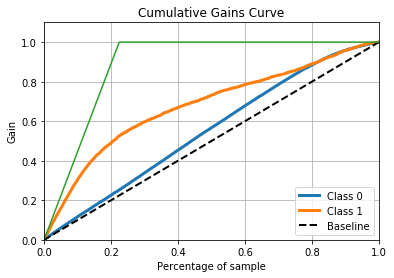

0.7295325023123027


<Figure size 432x288 with 0 Axes>

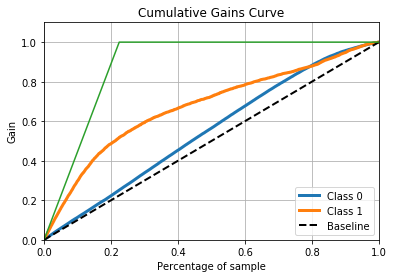

0.7250088545535862


In [375]:
cumul = np.zeros(len(y_thing)+1)
y_two = np.zeros(len(y_thing))
for i in range(len(y_thing)):
    y_two[i] = 1-y_thing[i]
y_T = np.c_[y_two,y_thing]

y_two2 = np.zeros(len(y_thing_self))
for i in range(len(y_thing_self)):
    y_two2[i] = 1-y_thing_self[i]
y_T2 = np.c_[y_two2,y_thing_self]
#     if y_thing[i] == 1:
#         cumul[i+1] = cumul[i]+1
#     else:
#         cumul[i+1] = cumul[i]
# c = 0
# for i  in range(len(yTest)):
#     if yTest[i]==1:
#         c+=1
# print(c)

# c = 0
# for i  in range(len(yTest)):
#     if y_thing[i]==1:
#         c+=1
# print(c)
import scikitplot as skplt
# print(np.shape(yTest.ravel()),np.shape(y_thing))
y_t = y_thing.reshape(len(y_thing))
# print(np.shape(y_t))
import matplotlib.pyplot as plt

plt.figure()
skplt.metrics.plot_cumulative_gain(yTest.ravel(), y_T2)
x, best = bestCurve(defaults=defaults, total=total, defaultRate=defaultRate)  
# plt.figure()
plt.plot(x, best)    
plt.ylim(top=1.1)
plt.show()
print(sklearn.metrics.roc_auc_score(yTest, y_thing_self))
plt.figure()
skplt.metrics.plot_cumulative_gain(yTest.ravel(), y_T)

# plt.plot(cumul)
defaults = sum(yTest == 1)
total = len(yTest)
defaultRate = defaults/total
def bestCurve(defaults, total, defaultRate):
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3

x, best = bestCurve(defaults=defaults, total=total, defaultRate=defaultRate)  
# plt.figure()
plt.plot(x, best)    
plt.ylim(top=1.1)
plt.show()

print(sklearn.metrics.roc_auc_score(yTest, y_thing))

In [308]:
#Read data and define methods and initialization seeds to run over
XTrain,XTest,yTrain,yTest = ReadData()
methods = ['NR','GD','SGD','SGDmb','skl']
seeds = [77,9865,75,34,875]
seeds = [858,8]

6636


In [363]:
#run regressions
for seed in seeds:
    print("Seed is {}.".format(seed))
    for method in methods:
        SGD(XTrain,yTrain,XTest,yTest,gd_method=method,seed=seed)

Seed is 858.
[[11235  2454]
 [  402   909]]
Accuracy baseline:           0.775800
Accuracy of NR method:       0.809600
---------------------------------------
[[11050  2418]
 [  587   945]]
Accuracy baseline:           0.775800
Accuracy of GD method:       0.799667
---------------------------------------
[[11237  2468]
 [  400   895]]
Accuracy baseline:           0.775800
Accuracy of SGD method:      0.808800
---------------------------------------
[[10827  2351]
 [  810  1012]]
Accuracy baseline:           0.775800
Accuracy of SGDmb method:    0.789267
---------------------------------------
[[11229  2511]
 [  408   852]]
Accuracy baseline:           0.775800
Accuracy of skl method:      0.805400
---------------------------------------
Seed is 8.
[[11235  2454]
 [  402   909]]
Accuracy baseline:           0.775800
Accuracy of NR method:       0.809600
---------------------------------------
[[10984  2496]
 [  653   867]]
Accuracy baseline:           0.775800
Accuracy of GD method:   

In [ ]:
# conf matrix!

In [ ]:
 sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)

In [261]:
import sklearn

In [269]:
## start NN fun

In [372]:
layers = np.arange(1,5)

a_matrix = np.zeros((XTrain.shape[0],len(layers)))
w_matrix = np.random.randn((XTrain.shape[0],len(layers)))
b = np.random.randn(len(layers))

# INITIALIZE
a_matrix[0,:] = sigmoid(XTrain[0,:]@w_matrix[0,:]+b[0])

# #ffeed forward
for layer in layers:
    
#calculate error

#backpropagating

#calculate gradients
